<a href="https://colab.research.google.com/github/phoenixfin/deeplearning-notebooks/blob/main/Praktikum_DL_3_Jaringan_Dangkal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum Pembelajaran Mendalam 3
## Shallow Neural Network
> Aditya Firman Ihsan




Pada praktikum ini, kita akan membangun model klasifikasi untuk mengelompokkan titik-titik pada $\mathbb{R}^2$ dengan 2 label sederhana. Hasilnya, ruang $\mathbb{R}^2$ akan terpisah menjadi 2 region yang saling lepas berdasarkan data yang digunakan.

Akan dilakukan dua pendekatan untuk model tersebut, yakni regresi logistik dan *artificial neural network* dengan satu layar tersembunyi (*hidden layer*), yang sering juga disebut dengan *shallow neural network* (untuk membedakan dengan *deep* network yang menggunakan lebih dari 1 *hidden layer*. 

### 1. Persiapan


#### 1.1. Import library

Seperti biasa, kita impor dulu semua yang dibutuhkan:
- [numpy](www.numpy.org): Numerical python, untuk hitung-hitung
- [matplotlib](http://matplotlib.org): MATLAB-nya python, untuk plotting
- [sklearn](https://scikit-learn.org/0.16/index.html), singkatan dari *sckit-learn* dimana *sckit* sendiri berarti SciPy Toolkit, merupakan ekstensi dari library SciPy khusus untuk *Machine Learning*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sds

#### 1.2. Menyiapkan dataset 

Dataset yang akan digunakan pada praktikum ini merupakan data dummy yang dibangkitkan menggunakan modul `daatasets` dari library `sklearn`. Data terdiri dari kumpulan titik-titik berdimensi 2 yang masing-masing diberi label 0 atau 1. Ada beberapa bentuk dataset yang akan disediakan. Untuk itu, cukup jalankan kode di bawah ini (dan pelajari sendiri jika penasaran).

In [ ]:
class PlanarDataset(object):
    def __init__(self, points_per_class):
        self.N = points_per_class

    def load_dataset(self, shape):
        X, Y = getattr(self, "get_"+shape)()
        X, Y = X.T, np.expand_dims(Y, 0)
        return X, Y
        
    def get_circles(self):
        return sds.make_circles(n_samples=self.N, factor=.5, noise=.3)

    def get_moons(self):      
        return sds.make_moons(n_samples=self.N, noise=.2)

    def get_blobs(self):
        X, Y = sds.make_blobs(n_samples=self.N, random_state=5, n_features=2, centers=6)
        Y = Y%2
        return X, Y

    def get_quantiles(self):
        return sds.make_gaussian_quantiles(mean=None, cov=0.5, 
                                           n_samples=self.N, n_features=2, 
                                           n_classes=2, shuffle=True, 
                                           random_state=None)      

    def get_random(self):
        return np.random.rand(self.N, 2), np.random.randint(2, size=self.N)

    def get_plain(self):
        X, Y = sds.make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                       n_informative=2, random_state=1, 
                                       n_clusters_per_class=1)
        rng = np.random.RandomState(2)
        X += 2 * rng.uniform(size=X.shape)
        return X, Y

    def get_flower(self):
        m = int(self.N / 2.)
        X = np.zeros((self.N,2)) # data matrix where each row is a single example
        Y = np.zeros(self.N, dtype='uint8') # labels vector (0 for red, 1 for blue)
        a = 4 # maximum ray of the flower

        for j in range(2):
            ix = range(m*j, m*(j+1))
            t = np.linspace(j*3.12, (j+1)*3.12, m) + np.random.randn(m)*0.2 # theta
            r = a * np.sin(4*t) + np.random.randn(m)*0.2 # radius
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[ix] = j

        return X, Y

Mula-mula, kita akan gunakan data yang paling sederhana, yakni yang berbentuk `plain`. Kita coba periksa datanya seperti apa.

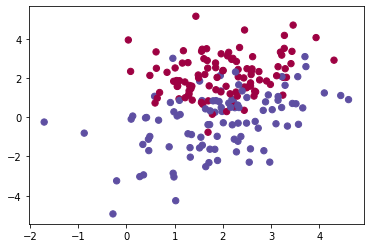

In [ ]:
loader = PlanarDataset(200)
X, Y = loader.load_dataset('plain')
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Perhatikan bahwa data seperti sudah terkelompokkan berdasarkan label, dengan beberapa data pencilan. Model yang akan dibangun harus bisa memisahkan kedua label data ini.

#### 1.3. Menyiapkan beberapa fungsi pendukung

Kita definisikan paling tidak dua fungsi berikut yang kelak akan kita pakai.
1. Fungsi untuk membuat "batas keputusan", yakni pemisah $\mathbb{R}^2$ menjadi 2 region saling lepas berdasarkan label.  

In [ ]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

2. Fungsi untuk memetakan seluruh bilangan Riil ke rentang $[0,1]$, karena luaran akhir dari model kita harus berupa kelas label. Banyak fungsi yang dapat digunakan, tapi yang cukup sering dipakai, dengan beberapa kelebihannya, adalah fungsi sigmoid

In [ ]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

### 2. Regresi Logistik

Model ini serupa dengan model regresi linear yang telah kita bangun di praktikum sebelumnya. Satu-satunya perbedaan adalah bahwa dalam regresi logistik luaran akhir dari regresi linear dimasukkan ke fungsi sigmoid untuk bisa menghasilkan nilai antara 0 dan 1. 

#### 2.1. Membangun Model

Perhatikan kode di bawah ini, serupa dengan kode versi OOP regresi linear pada praktikum sebelumnya, dengan perbedaan mendasar pada perhitungan nilai *cost* $C$ saat propagasi maju dan perhitungan turunan $\frac{dC}{dz}$ saat propagasi mundur.

In [ ]:
class LogisticRegressor(object):
    def __init__(self, cost_log = True):
        self.W = None
        self.b = None
        self.print_cost = cost_log

    def initialize_random(self, num_features):
        self.w = np.random.rand(num_features, 1)
        self.b = np.random.rand(1)
        self.costs = []

    def setup(self, X, Y, num_iterations = 2000, learning_rate = 0.5):
        self.initialize_random(X.shape[0])
        self.X = X.T
        self.Y = Y.reshape((Y.shape[1], Y.shape[0]))
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate

    def propagate(self):
        N = self.X.shape[0]

        # Forward
        Z = np.dot(self.X, self.w) + self.b
        #### Perbedaan dengan regresi linear 
        A = sigmoid(Z)
        logprob = np.multiply(np.log(A), self.Y) + np.multiply(np.log(1-A), 1-self.Y)
        self.costs.append(- np.sum(logprob) / N)
        #####

        # Backward
        e = self.Y - A
        #### Perbedaan dengan regresi linear
        dz = - e / N
        #####
        dw = np.dot(self.X.T, dz)
        db = np.sum(dz)
        
        return dw, db

    def optimize(self):
        for i in range(self.num_iterations):
            dw, db = self.propagate()

            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db
            
            if (i % 100 == 0) and (self.print_cost):
                  print ("Cost after iteration %i: %f" %(i, self.costs[i]))

    def predict(self, X_pred):
        forward = np.dot(X_pred, self.w) + self.b
        predictions = forward > 0.5  
        return predictions

    def get_accuracy(self):
        Y_pred = self.predict(self.X)
        correct = np.dot(self.Y.T, Y_pred) + np.dot(1-self.Y.T, 1-Y_pred)
        accuracy = float(correct)/float(self.Y.size)*100  
        print("train accuracy: {} %".format(accuracy))

    def train(self):
        self.optimize()


#### 2.2. Melatih Model

Model di atas dapat langsung dibangun. Kita lakukan ujicoba pada data `plain` yang sudah kita periksa sebelumnya.


In [ ]:
model = LogisticRegressor()
model.setup(X, Y, num_iterations = 2000, learning_rate = 0.05)
model.train()
model.get_accuracy()

Cost after iteration 0: 1.062082
Cost after iteration 100: 0.392960
Cost after iteration 200: 0.367510
Cost after iteration 300: 0.359432
Cost after iteration 400: 0.356061
Cost after iteration 500: 0.354455
Cost after iteration 600: 0.353624
Cost after iteration 700: 0.353170
Cost after iteration 800: 0.352910
Cost after iteration 900: 0.352755
Cost after iteration 1000: 0.352660
Cost after iteration 1100: 0.352599
Cost after iteration 1200: 0.352558
Cost after iteration 1300: 0.352530
Cost after iteration 1400: 0.352511
Cost after iteration 1500: 0.352496
Cost after iteration 1600: 0.352485
Cost after iteration 1700: 0.352477
Cost after iteration 1800: 0.352470
Cost after iteration 1900: 0.352465
train accuracy: 85.5 %


Perhatikan bahwa kita dapatkan akurasi 85 persen, artinya dari 200 titik data yang ada, sekitar 30 di antaranya masih keliru diprediksi.

Kita coba lihat visualisasinya menggunakan fungsi pembuat batas pemisah yang sudah didefinisikan sebelumnya. 

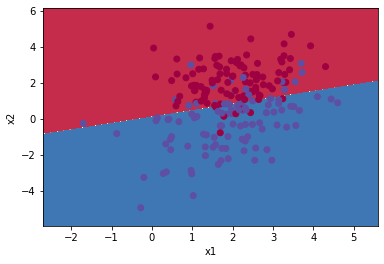

In [ ]:
# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, Y)

### 3. Jaringan Neural Dangkal

Meskipun sudah menghasilkan luaran yang sangat baik, 85 persen masih jauh dari sempurna. Kita ingin meningkatkan akurasi model lebih baik lagi. Untuk itu, kita akan gunakan pendekatan yang berbeda.

#### 3.1. Membangun model

Kita tidak akan langsung gunakan OOP. Agar mudah memahami dulu, kita bangun modelnya perlahan. Mula-mula, kita siapkan beberapa fungsi dasar.

##### 3.1.1. Inisialisasi parameter 

Kita definisikan fungsi untuk menginisialisasi parameter bobot $w$ dan parameter bias $b$. Kita gunakan pendekatan campuran di sini, yakni $w$ kita inisialisasi secara acak, sedangkan $b$ kita inisialisasi dengan nol.

In [ ]:
def initialize_parameters(n_x, n_h, n_y):    
    w1 = np.random.randn(n_h, n_x) 
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_y, n_h) 
    b2 = np.zeros((n_y,1))
    
    return w1, w2, b1, b2

##### 3.1.2. Propagasi

Selanjutnya, kita definisikan fungsi untuk propagasi perhitungannya. Kali ini, kita pisah jadi dua fungsi agar mudah untuk dibaca. Ingat bahwa propagasi maju adalah untuk mneghitung nilai luaran dari tiap neuron-nya, dan propagasi mundur adalah untuk menghitung gradient dari nilai $C$ terhadap tiap parameternya. 

In [ ]:
def forward_propagation(X, w1, w2, b1, b2):
    Z1 = np.dot(w1, X)+ b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(w2, A1) + b2
    A2 = sigmoid(Z2)
        
    return A1, A2

In [ ]:
def backward_propagation(A1, A2, w2, X, Y):
    m = X.shape[1]

    dZ2 = A2 - Y
    dw2 = np.dot(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    dZ1 = np.dot(w2.T, dZ2) * (1. - np.power(A1, 2))
    dw1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    
    return dw1, dw2, db1, db2

##### 3.1.3 Optimisasi

Tak lupa kita definisikan fungsi untuk update parameter di tiap iterasinya sebagai bagian dari proses optimisasi

In [ ]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    w1, w2, b1, b2 = parameters
    dw1, dw2, db1, db2 = grads

    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
        
    return w1, w2, b1, b2

##### 3.1.4. Pelengkap

Sebelum kita definisikan modelnya, beberapa fungsi pelengkap lagi perlu didefinisikan. Perlu dipahami bahwa fungsi-fungsi di bawah ini bukan bagian dari proses learning itu sendiri, tapi hanya kebutuhan programmer untuk melacak proses.

In [ ]:
def compute_cost(A2, Y):
    m = Y.shape[1] # number of example

    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)
    cost = - np.sum(logprobs)/m
    
    return float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 

In [ ]:
def predict(parameters, X):    
    _, A2 = forward_propagation(X, *parameters)
    predictions = A2 > 0.5
    
    return predictions

In [ ]:
def get_accuracy(parameters, X, Y):
    predictions = predict(parameters, X)
    correctly_predicted = np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T)
    accuracy = float(correctly_predicted)/float(Y.size)*100  
    print("train accuracy: {} %".format(accuracy))

##### 3.1.5. Bungkus!



Barulah kemudian kita bisa bangun modelnya

In [ ]:
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 1.2, print_cost=False):    
    n_x = X.shape[0]
    n_y = Y.shape[0]
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
        A1, A2 = forward_propagation(X, *parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(A1, A2, parameters[1], X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % (num_iterations // 10) == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

#### 3.2. Melatih Model

Tentukan terlebih dahulu berapa neuron yang termuat dalam *hidden layer*. Ini menentukan kompleksitas hasil

In [ ]:
hidden_neuron = 4

Kemudian kita masukkan semua yang dibutuhkan ke model yang tellah dibangun

In [ ]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, hidden_neuron, 100000, 0.5, True)
get_accuracy(parameters, X, Y)

Cost after iteration 0: 1.049739
Cost after iteration 10000: 0.330148
Cost after iteration 20000: 0.326015
Cost after iteration 30000: 0.320643
Cost after iteration 40000: 0.318835
Cost after iteration 50000: 0.317766
Cost after iteration 60000: 0.317015
Cost after iteration 70000: 0.316497
Cost after iteration 80000: 0.316150
Cost after iteration 90000: 0.315889
train accuracy: 87.0 %


Wah, akurasi yang didapatkan tidak signifikan. Pada beberapa kasus (bersifat acak tergantung inisiaisasi parameter awal), bahkan akurasinya bisa lebih buruk.
Coba kita lihat dulu pembagian region-nya

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

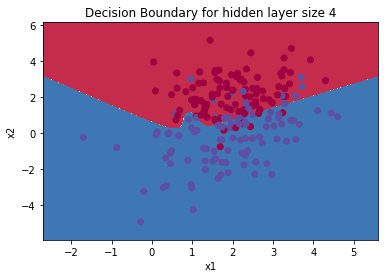

In [ ]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(hidden_neuron))

Terlihat bahwa batas pembagi yang terbuat tidak lagi sesederhana garis lurus seperti pada regresi logistik. 

### 4. Eksplorasi

#### 4.1. Dataset Bentuk Lain

Setiap alat ada peruntukannya masing-masing. Menggunnakan gergaji untuk memotong wortel tidak akan menambah efektif pemotongannya, justru bahkan bisa jadi lebih menyulitkan. Semakin canggih alat, bukan berarti semakin baik.

Sekarang kita akan buktikan itu dengan data lain. Selain data yang `plain`, kita bisa buat berbagai bentuk data. Kita coba periksa data-nya satu per satu.

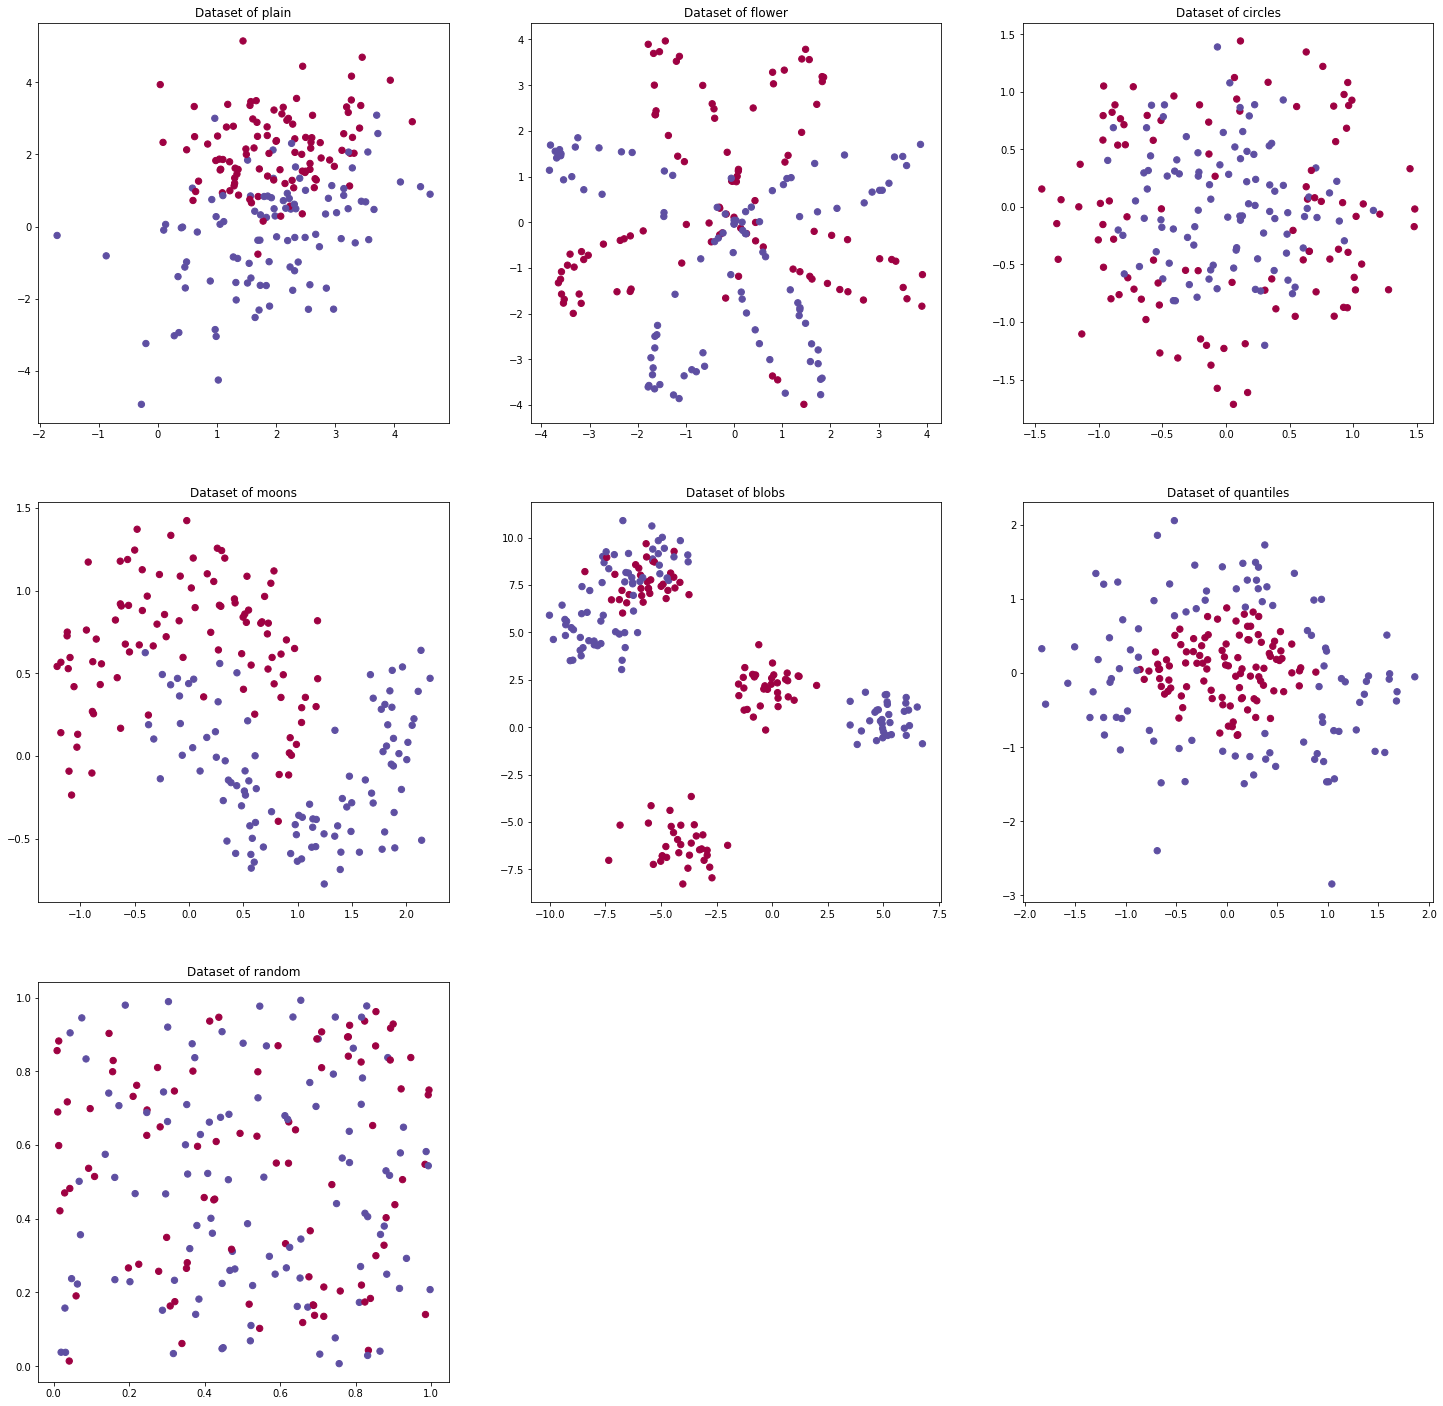

In [ ]:
dataset_lst = [
    'plain', #0
    'flower', #1
    'circles', #2
    'moons', #3
    'blobs', #4
    'quantiles', #5 
    'random' #6
]
plt.figure(figsize=(25, 25))
for i, shape in enumerate(dataset_lst):
    plt.subplot(3, 3, i+1)
    plt.title("Dataset of "+shape)
    X, Y = loader.load_dataset(shape)  
    plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Data-data ini tentu tidak dapat diklasifikasikan dengan mudah. Misalkan kita coba pake regresi logistik untuk klasiikasi data Flower.

Cost after iteration 0: 0.698366
Cost after iteration 100: 0.690907
Cost after iteration 200: 0.690530
Cost after iteration 300: 0.690340
Cost after iteration 400: 0.690179
Cost after iteration 500: 0.690039
Cost after iteration 600: 0.689917
Cost after iteration 700: 0.689811
Cost after iteration 800: 0.689718
Cost after iteration 900: 0.689638
Cost after iteration 1000: 0.689568
Cost after iteration 1100: 0.689507
Cost after iteration 1200: 0.689454
Cost after iteration 1300: 0.689407
Cost after iteration 1400: 0.689367
Cost after iteration 1500: 0.689331
Cost after iteration 1600: 0.689300
Cost after iteration 1700: 0.689273
Cost after iteration 1800: 0.689249
Cost after iteration 1900: 0.689229
train accuracy: 47.5 %


Text(0.5, 1.0, 'Decision Boundary for logistic regression')

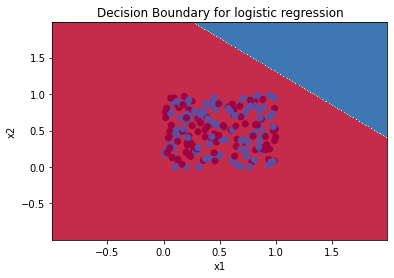

In [ ]:
X, Y = loader.load_dataset("random")  
model = LogisticRegressor()
model.setup(X, Y, num_iterations = 2000, learning_rate = 0.05)
model.train()
model.get_accuracy()
# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, Y)
plt.title("Decision Boundary for logistic regression")

Terlihat bawha penggunaan batas pemisah yang linier tidak akan bisa mengklasifikasikan data Flower dengan baik. Akurasinya bahkan hanya sekitar 50 persen. Lagipula, karena ini klasifikasi biner, bahkan jika modelnya selalu memprediksi semua titik apapun sebagai merah (atau biru) pun pasti akurasinya 50 persen. Pada data-data seperti ini lah model jaringan neural akan berfungsi dengan baik.

Cost after iteration 0: 1.600312
Cost after iteration 10000: 0.680386
Cost after iteration 20000: 0.678978
Cost after iteration 30000: 0.677019
Cost after iteration 40000: 0.668767
Cost after iteration 50000: 0.658884
Cost after iteration 60000: 0.657813
Cost after iteration 70000: 0.657548
Cost after iteration 80000: 0.657317
Cost after iteration 90000: 0.657099
train accuracy: 64.0 %


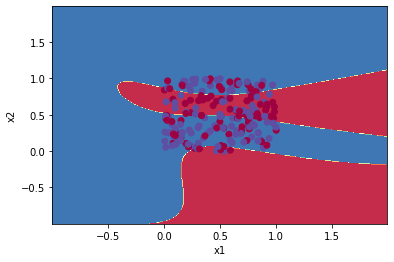

In [ ]:
parameters = nn_model(X, Y, 8, 100000, 0.05, True)
get_accuracy(parameters, X, Y)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

(HASIL DI ATAS MASIH MAU DIPERBAIKI)


#### 4.2. Sensitivitas Jumlah Neuron

Sebenarnya apa sih fungsi sesungguhnya dari *hidden layer*? Ia semacam menyediakan/membentuk variabel fitur tambahan yang lebih kompleks dari fitur yang asli. Misal fitur yang asli cuma berupa nilai ordinat dan absis dari titiknya, maka *hidden layer* bisa membentuk fitur berupa kuadrat dari ordinatnya (misal), atau berupa hasil kali ordinat dan absisnya, sehingga pemisah yang non liner dapat terbentuk.

Tentu semakin banyak neuron pada *hidden layer* akan menentukan kompleksitas yang dihasilkan, karena satu neuron mewakili 1 fitur tambahan. Akan tetapi, ada nilai optimalnya, dimana neuron yang terlalu banyak tidak akan terlalu menambah akurasi yang signifikan. Penasaran? Coba kerjakan sendiri ya!

### Tugas

Lakukan analisis sensitivitas jumlah neuron pada setiap dataset selain yang plain. Plot *decision boundary* dari setiap hasil training. Juga, plot akurasi berbanding jumlah neuron pada setiap dataset.

Jelaskan hasil analisismu.

#### (Jawaban)

**Catatan Untuk Grader**

Kode di bawah hanya contoh, yang penting:
1. Mereka menganalisis setiap dataset
2. Mereka mencoba plot minimal untuk 4 case jumlah hidden layer
3. Mereka plot boundary decision setiap hasil training dan mencatat akurasinya
4. Mereka plot grafik akurasi berbanding jumlah hidden layer pada setiap dataset
5. Mereka analisis hasil plot

Accuracy for 1 hidden units: 72.0 %
Accuracy for 6 hidden units: 96.0 %
Accuracy for 11 hidden units: 97.0 %
Accuracy for 16 hidden units: 98.5 %
Accuracy for 21 hidden units: 98.5 %
Accuracy for 26 hidden units: 99.0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Accuracy for 31 hidden units: 99.0 %
Accuracy for 36 hidden units: 99.0 %
Accuracy for 41 hidden units: 98.5 %
Accuracy for 46 hidden units: 98.5 %


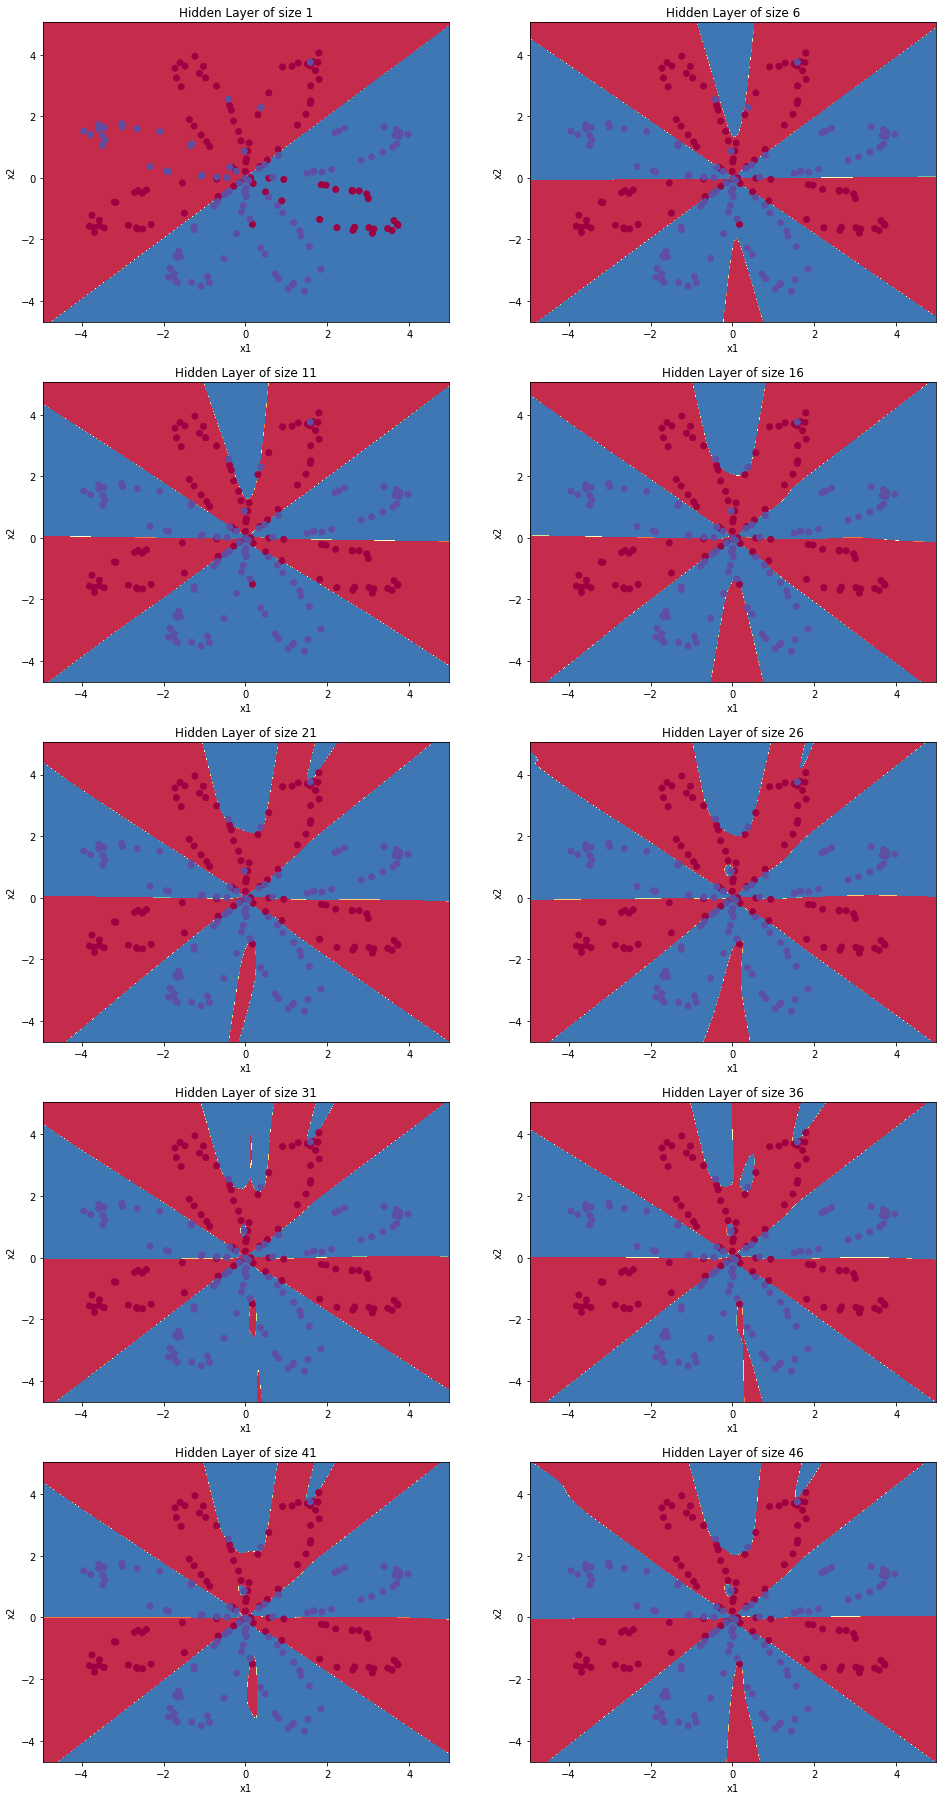

In [ ]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = np.arange(1, 50, 5)
accuracy = []
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)

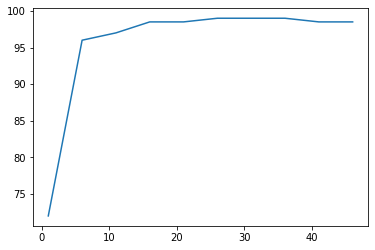

In [ ]:
plt.plot(hidden_layer_sizes, accuracy)

## Appendiks

Yang mau bermain-main dengan klasifikasi biner seperti ini, bisa langsung coba-coba saja di playground-nya tensorflow yang dikembangkan Google untuk memberi gambaran tentang Deep Learning

### [Klik di sini!](http://playground.tensorflow.org/)